In [1]:
%matplotlib inline
from brian2 import *

### [Exercise: time dependent current]

Replace the injected current in the model above by a current that changes in time.

*Hints:*

* Equations can refer to all defined constants and variables, as well as to a few standard variables/constants that are predefined, e.g.:

`N` (number of neurons in the group), `i` (index of the neuron), `t` (current time), `dt` (the time step used for the simulation)
* Equations can make use of standard mathematical functions, e.g. `exp`, `sin`, `sqrt`, ...
* Equations can be made more readable by introducing "subexpressions", i.e. short names for longer terms. For example, the following two definitions do the same thing:


```Python
eqs = '''
dV_m/dt = (E_L - V_m + R*I_inj)/tau : volt
'''
eqs = '''
dV_m/dt = (E_L - V_m + V_inj)/tau : volt
V_inj = R*I_inj : volt
'''
```

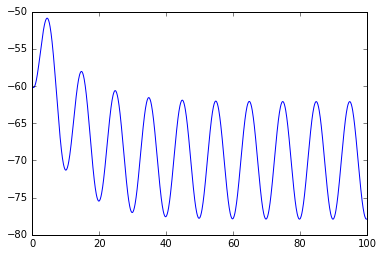

In [2]:
start_scope()

tau = 10*ms   # time constant
R = 50*Mohm   # membrane resistance
E_L = -70*mV  # leak reversal potential

eqs = '''
dV_m/dt = (E_L - V_m + R*I_inj)/tau : volt
# This is the new formulation that replaces the constant from before
I_inj = sin(2*pi*100*Hz*t)*1*nA : amp
'''

neuron = NeuronGroup(1, eqs)
neuron.V_m = -60*mV

mon = StateMonitor(neuron, 'V_m', record=True)

run(100*ms)
plot(mon.t/ms, mon.V_m[0]/mV)

### [Exercise: refractoriness, adaptive threshold]

1. What happens in the above model if you remove the `(unless refractory)` from the model? Explain what happens.
2. Implement an *adaptive threshold*. The new behaviour of the neuron should be like this (with $V_{th0}$ equal to the previous fixed threshold, i.e. $V_{th0} = -50\mathrm{mV}$, and $\tau_{th}=30\mathrm{ms}$):

$$
\tau\frac{d V_m}{dt} = E_L - V_m + R I_{inj}\\
\tau_{th}\frac{d V_{th}}{dt} = V_{th0} - V_{th}
$$
If $V_m > V_{th}$:
$$
V_m \leftarrow -60\mathrm{mV}\\
V_{th} \leftarrow V_{th} + 5\mathrm{mV}
$$


*Hint*: Note that the reset statement can in fact consist of multiple statements -- either use a Python multiline string, or separate statements with a semicolon.

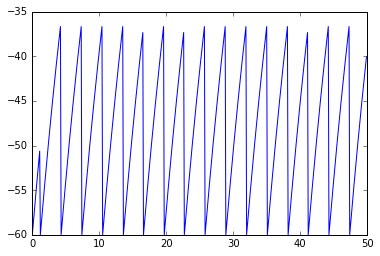

In [3]:
# Refractoriness without (unless refractory)
start_scope()

tau = 10*ms   # time constant
R = 50*Mohm   # membrane resistance
E_L = -70*mV  # leak reversal potential
I_inj = 2*nA  # injected current

eqs = '''
# "unless refractory" means that the differential equation is
# only used when the neuron is not in its refractory period.
# During the refractory period, the variable remains "clamped"
# at its current value
dV_m/dt = (E_L - V_m + R*I_inj)/tau : volt
'''

neuron = NeuronGroup(1, eqs, threshold='V_m>-50*mV',
                     reset='V_m=-60*mV',
                     refractory=3*ms)
neuron.V_m = -60*mV

mon = StateMonitor(neuron, 'V_m', record=0)
run(50*ms)
plot(mon.t/ms, mon.V_m[0]/mV)

Explanation: During the refractoriness, the neuron is not allowed to spike, so it will also not reset. Since there is no `(unless refractory)`, the membrane potential continues to increase due to the constant current input. At the end of the refractory period, the membrane potential is already considerably above threshold so a spike and reset is triggered immediately.

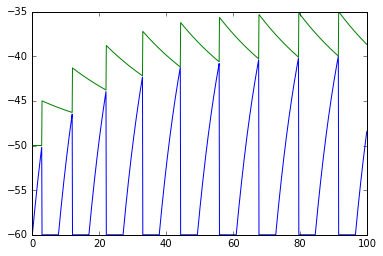

In [4]:
# Exercise solution: adaptive threshold

start_scope()

tau = 10*ms   # time constant
R = 50*Mohm   # membrane resistance
E_L = -70*mV  # leak reversal potential
I_inj = 1*nA  # injected current

eqs = '''
dV_m/dt = (E_L - V_m + R*I_inj)/tau : volt (unless refractory)
dV_t/dt = (-50*mV - V_t)/(30*ms) : volt
'''

neuron = NeuronGroup(1, eqs, threshold='V_m>V_t',
                     reset='''V_m=-60*mV
                              V_t += 5*mV''',
                     refractory=5*ms)
neuron.V_m = -60*mV
neuron.V_t = -50*mV

mon = StateMonitor(neuron, ['V_m', 'V_t'], record=0)
run(100*ms)
plot(mon.t/ms, mon.V_m[0]/mV)
plot(mon.t/ms, mon.V_t[0]/mV)